# The quest to find the closest ground pixel

The Sentinel-5P data I work on lately is typically organised on an irregular two-dimensional grid whose dimensions are *scanline* (along track dimension) and *ground pixel* (across track dimension). Latitude and longitude information for each ground pixel are stored in auxiliary coordinate variables.  

I have recently stumbled upon the problem of localising the closest ground pixel on the grid to a reference point, identified by its geodetic coordinates.

In this post, we are going to define an algorithm to solve this problem by using coordinate transformations and $k$-dimensional trees.

## Defining our dataset 

Let's get our hands dirty and start writing some code. As usual, let's import our libraries:

In [45]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from scipy import spatial
%matplotlib inline

To prototype our search algorithm, we are going to define a toy dataset, and store it into an xarray's `DataArray`. In an outburst of creativity, we could simulate some surface temperature measurements over Europe and the Mediterranean basin, on a 12x10 grid.

In [98]:
num_sl = 12 # number of scanlines
num_gp = 10 # number of ground pixels

lon, lat = np.meshgrid(np.linspace(-20, 20, num_gp),
                       np.linspace(30, 60, num_sl))
lon += lat/10
lat += lon/10

data = (np.linspace(30, 0, num_sl*num_gp).reshape(num_sl, num_gp) + 
        5*np.random.rand(num_sl, num_gp))

da = xr.DataArray(data, dims=['scanline', 'ground_pixel'],
                  coords = {'lat': (('scanline', 'ground_pixel'), lat),
                            'lon': (('scanline', 'ground_pixel'), lon)})

Let's have a quick look at our dataset.

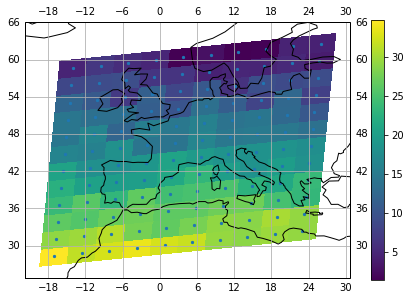

In [99]:
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
da.plot.pcolormesh('lon', 'lat', ax=ax, infer_intervals=True);
ax.scatter(lon, lat, transform=ccrs.PlateCarree(), s=5)
plt.tight_layout()

Doesn't that look suprisingly credible?

The blue dots in the plot identify the centre of each pixel, whose boundaries are automatically inferred by xarray.

What we want to achieve is to come up with a way to compare distances between a reference point, and all centre pixels. We could then identify the closest ground pixel by considering the minimum distance between the reference pixel and the centre pixels.

## On the distance between two points

How do we compute the distance between two points, give their geodetic (latitude/longitude/altitude) coordinates?
Despite a recent resurgence of the old myth, our earth is definitely not flat, thus, sadly, we won't be able to make use of the Pythagorean theorem for that.

The subject of [geographical distance](https://en.wikipedia.org/wiki/Geographical_distance) is considerably elaborated and I will not even try to cover it all in this post. 

Let's make our lives simpler by using the cartesian or [ECEF](https://en.wikipedia.org/wiki/ECEF) ("earth-centered, earth-fixed") geographic coordinate system, which represents positions (in meters) as $X$, $Y$, and $Z$ coordinates. That implies approximating the earth surface as an ellipsoid of revolution (close enough for our purposes!). Once we convert our points' geodetic coordinates to ECEF coordinates, we could simply compare them by computing the euclidean distance between them.

The conversion between cartesian and geodetic coordinates latitude, longitude and ellipsoidal $(\phi, \lambda, h)$ is done according to:

$$
\left[\begin{array}{c}X \\ Y \\ Z \end{array}\right] = \left[\begin{array}{c} (r_n+h) \cos\phi \cos\lambda \\ 
(r_n + h) \cos\phi \sin\lambda \\ 
((1 - e^2) r_n + h) \sin\phi \end{array}\right]
$$

Where $r_n=\frac{a}{\sqrt{1-e^2\sin^2\phi}}$ is the local curvature of the ellipsoid along the first vertical, and where $e$, the first eccentricity, and $a$, the semi-major axis, are the parameters defining the ellipsoid.  

Assuming that our dataset provides coordinates of the centre pixel on the earth's surface ($h = 0$), we can derive the following conversion formulas:

$$
\left[\begin{array}{c}X \\ Y \\ Z \end{array}\right] = \left[\begin{array}{c} r_n+h \cos\phi \cos\lambda \\ 
r_n \cos\phi \sin\lambda \\ 
(1 - e^2) r_n \sin\phi \end{array}\right]
$$

Now that we learned a bit of [MathJax](https://www.mathjax.org) and found a way to convert our pixels' coordinates in cartesian coordinates, let's start to think about an efficient way to compute the minimum distance between all pixels and a reference point.

## Finding the closest

Our problem falls into the class of nearest neighbour searches. A common approach when it comes to finding the nearest neighbour in a number of points with $k$ dimensions is to use a kd-tree, or $k$-dimensional tree; kd-trees allow to efficiently perform searches like "all points at distance lower than $R$ from $X$" or "$k$ nearest neighbors of $X$".  

Luckily, the SciPy library provides a very efficient [kd-tree implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html) so we will be spared from having to write our own. Once we istantiate our tree, all we have to do is to populate it with a $(n, m)$ shaped array of points and then query it the nearest neighbor to a reference point. In our case $n$ will be equal to the total number of ground pixels, and $m$ will be 3, as in our three dimensions $X$, $Y$, and $Z$.

We will make use of some NumPy acrobatics to reshape our data structures from a two-dimensional grid to a one-dimensional array, and to convert the restituded one-dimensional index to a set of two indices on our original grid. For sake of efficiency, we can wrap the geodetic coordinates conversion and the kd-tree initialization in a class. In this way, we won't have to transform coordinates and reconstruct the tree each time we want to find a new neighbo

In [116]:
coords = np.column_stack((da.lat.values.reshape(num_sl*num_gp),
                          da.lon.values.reshape(num_sl*num_gp)))
coords[:,0]

array([ 28.3       ,  28.74444444,  29.18888889,  29.63333333,
        30.07777778,  30.52222222,  30.96666667,  31.41111111,
        31.85555556,  32.3       ,  31.05454545,  31.4989899 ,
        31.94343434,  32.38787879,  32.83232323,  33.27676768,
        33.72121212,  34.16565657,  34.61010101,  35.05454545,
        33.80909091,  34.25353535,  34.6979798 ,  35.14242424,
        35.58686869,  36.03131313,  36.47575758,  36.92020202,
        37.36464646,  37.80909091,  36.56363636,  37.00808081,
        37.45252525,  37.8969697 ,  38.34141414,  38.78585859,
        39.23030303,  39.67474747,  40.11919192,  40.56363636,
        39.31818182,  39.76262626,  40.20707071,  40.65151515,
        41.0959596 ,  41.54040404,  41.98484848,  42.42929293,
        42.87373737,  43.31818182,  42.07272727,  42.51717172,
        42.96161616,  43.40606061,  43.85050505,  44.29494949,
        44.73939394,  45.18383838,  45.62828283,  46.07272727,
        44.82727273,  45.27171717,  45.71616162,  46.16

In [123]:
class GroundPixelKDTree():
    
    """ A kd-tree implementation for lat/lon coordinates.
    
    Keyword arguments: 
    dataset -- a xarray DataArray containing lat/lon coordinates
               (named 'lat' and 'lon' respectively)
               
    """
    
    def transform_coordinates(self, coords):
        """ Transform coordinates from geodetic to cartesian
        
        Keyword arguments:
        coords - a set of lan/lon coordinates
        """
        # WGS 84 reference coordinate system parameters
        A = 6378.137 # major axis [km]   
        E2 = 6.69437999014e-3 # eccentricity squared    
        
        coords = np.asarray(coords).astype(np.float)
        
        # is coords a tuple? Covert it to an one-element array of tuples
        if coords.ndim == 1:
            coords = np.array([coords])
        
        # reshape and convert coordinates from degrees to radiants
        lat_rad = np.radians(coords[:,0])
        lon_rad = np.radians(coords[:,1]) 
        
        # convert to cartesian coordinates
        r_n = A / (np.sqrt(1 - E2 * (np.sin(lat_rad) ** 2)))
        x = r_n * np.cos(lat_rad) * np.cos(lon_rad)
        y = r_n * np.cos(lat_rad) * np.sin(lon_rad)
        z = r_n * (1 - E2) * np.sin(lat_rad)
        
        return np.column_stack((x, y, z))
    
    def __init__(self, dataset):
        self.num_sl = dataset.shape[0]
        self.num_gp = dataset.shape[1]   
        
        # reshape and stack coordinates
        coords = np.column_stack((dataset.lat.values.reshape(num_sl*num_gp),
                                  dataset.lon.values.reshape(num_sl*num_gp)))
        
        # construct kd-tree
        self.tree = spatial.KDTree(self.transform_coordinates(coords))
        
    def closest(self, point):
        """ Query the kd-tree for nearest neighbour.
        
        Keyword arguments:
        point -- a (lat, lon) tuple
        """
        _, index = self.tree.query(self.transform_coordinates(point))
        
        return np.unravel_index(index, (self.num_sl, self.num_gp))

In [124]:
ground_pixel_tree = GroundPixelKDTree(da)

In [125]:
rome = (41.9028, 12.4964)
point = (66, 30)
coords = np.asarray(rome).astype(np.float)
coords = np.array([coords])
coords[:, 0]

array([ 41.9028])

In [127]:
ground_pixel_tree.transform_coordinates(rome)

array([[ 4641.58698501,  1028.70909187,  4237.57454874]])

In [128]:
ground_pixel_tree.closest(rome)

(array([4]), array([6]))

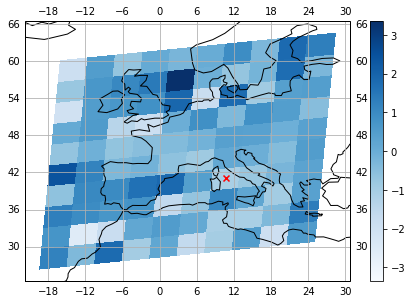

In [149]:
ax = plt.subplot(projection=ccrs.PlateCarree())
da.plot.pcolormesh('lon', 'lat', ax=ax, cmap=plt.cm.get_cmap('Blues'), 
                   infer_intervals=True);
ax.scatter(da.lon[pixel_coords], da.lat[pixel_coords], 
           marker='x', color='r', transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.tight_layout()

## 